## 放在caffe/examples文件夹下 python2.7

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
import os

In [2]:
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


In [3]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
#     padding = (((0, n ** 2 - data.shape[0]),
#                (0, 1), (0, 1))                 # add some space between filters
#                + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
#     data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.imshow(data); plt.axis('off')
#     plt.savefig('test.png',frameon=False)

In [4]:
!diff net_surgery/bvlc_caffenet_full_conv.prototxt ../models/bvlc_reference_caffenet/deploy.prototxt

1,2c1
< # Fully convolutional network version of CaffeNet.
< name: "CaffeNetConv"
---
> name: "CaffeNet"
7,11c6
<   input_param {
<     # initial shape for a fully convolutional network:
<     # the shape can be set for each input by reshape.
<     shape: { dim: 1 dim: 3 dim: 451 dim: 451 }
<   }
---
>   input_param { shape: { dim: 10 dim: 3 dim: 227 dim: 227 } }
157,158c152,153
<   name: "fc6-conv"
<   type: "Convolution"
---
>   name: "fc6"
>   type: "InnerProduct"
160,161c155,156
<   top: "fc6-conv"
<   convolution_param {
---
>   top: "fc6"
>   inner_product_param {
163d157
<     kernel_size: 6
169,170c163,164
<   bottom: "fc6-conv"
<   top: "fc6-conv"
---
>   bottom: "fc6"
>   top: "fc6"
175,176c169,170
<   bottom: "fc6-conv"
<   top: "fc6-conv"
---
>   bottom: "fc6"
>   top: "fc6"
182,186c176,180
<   name: "fc7-conv"
<   type: "Convolution"
<   bottom: "fc6-conv"
<   top: "fc7-conv"
<   convolution_param {
---
>   name: "fc7"
>   type: "InnerProduct"
>   bottom: "fc6"
>   top: "f

In [4]:
if os.path.isfile(caffe_root + 'examples/net_surgery/bvlc_caffenet_full_conv.caffemodel'):
    net_full_conv = caffe.Net('net_surgery/bvlc_caffenet_full_conv.prototxt', 
                          'net_surgery/bvlc_caffenet_full_conv.caffemodel',
                          caffe.TEST)
else:
    # Load the original network and extract the fully connected layers' parameters.
    net = caffe.Net('../models/bvlc_reference_caffenet/deploy.prototxt', 
                    '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel', 
                    caffe.TEST)
    params = ['fc6', 'fc7', 'fc8']
    # fc_params = {name: (weights, biases)}
    fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}
#     for fc in params:
#         print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)
    # Load the fully convolutional network to transplant the parameters.
    net_full_conv = caffe.Net('net_surgery/bvlc_caffenet_full_conv.prototxt', 
                              '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                              caffe.TEST)
    params_full_conv = ['fc6-conv', 'fc7-conv', 'fc8-conv']
    # conv_params = {name: (weights, biases)}
    conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}
#     for conv in params_full_conv:
#         print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)
    for pr, pr_conv in zip(params, params_full_conv):
        conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
        conv_params[pr_conv][1][...] = fc_params[pr][1]
    net_full_conv.save('net_surgery/bvlc_caffenet_full_conv.caffemodel')

In [9]:
# for each layer, show the output shape
for layer_name, blob in net_full_conv.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 451, 451)
conv1	(1, 96, 111, 111)
pool1	(1, 96, 55, 55)
norm1	(1, 96, 55, 55)
conv2	(1, 256, 55, 55)
pool2	(1, 256, 27, 27)
norm2	(1, 256, 27, 27)
conv3	(1, 384, 27, 27)
conv4	(1, 384, 27, 27)
conv5	(1, 256, 27, 27)
pool5	(1, 256, 13, 13)
fc6-conv	(1, 4096, 8, 8)
fc7-conv	(1, 4096, 8, 8)
fc8-conv	(1, 1000, 8, 8)
prob	(1, 1000, 8, 8)


In [10]:
for layer_name, param in net_full_conv.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6-conv	(4096, 256, 6, 6) (4096,)
fc7-conv	(4096, 4096, 1, 1) (4096,)
fc8-conv	(1000, 4096, 1, 1) (1000,)


In [71]:
 net_full_conv.blobs['data'].data.shape

(1, 3, 451, 451)

[[282 282 281 281 281 281 277 282]
 [281 283 283 281 281 281 281 282]
 [283 283 283 283 283 283 287 282]
 [283 283 283 281 283 283 283 259]
 [283 283 283 283 283 283 283 259]
 [283 283 283 283 283 283 259 259]
 [283 283 283 283 259 259 259 277]
 [335 335 283 259 263 263 263 277]]


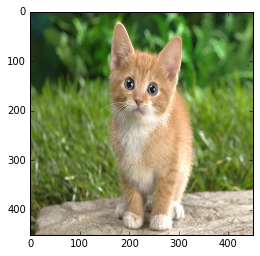

In [5]:
# load input and configure preprocessing
im = caffe.io.load_image('images/cat.jpg')
transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
transformer.set_mean('data', np.load('../python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)
# make classification map by forward and print prediction indices at each location
out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
print out['prob'][0].argmax(axis=0)
# show net input and confidence map (probability of the top prediction at each location)
# plt.subplot(1, 2, 1)
plt.imshow(transformer.deprocess('data', net_full_conv.blobs['data'].data[0]))
# plt.subplot(1, 2, 2)
# plt.imshow(out['prob'][0,169])

In [51]:
feat = net_full_conv.blobs['pool5'].data[0,5:6]

In [58]:
data = feat.transpose((1,2,0))[:,:,0]
data = np.array(data)

In [60]:
new_im = Image.fromarray(data)

In [61]:
new_img = new_im.resize((480,360),Image.BILINEAR)

In [72]:
img = np.asarray(new_img)

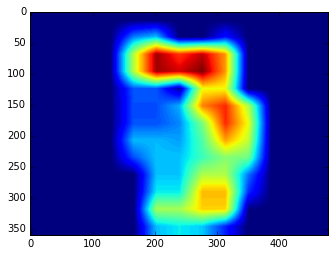

In [74]:
plt.imshow(img);plt.axis('off')
#plt.savefig('test.png',frameon=False)

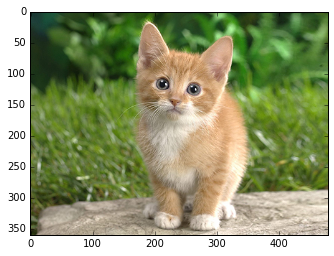

In [25]:
plt.imshow(im)

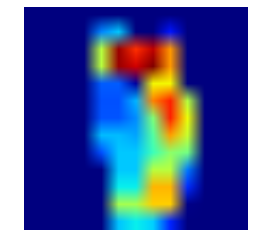

In [11]:
vis_square(feat)

blobs ['data', 'conv']
params ['conv']


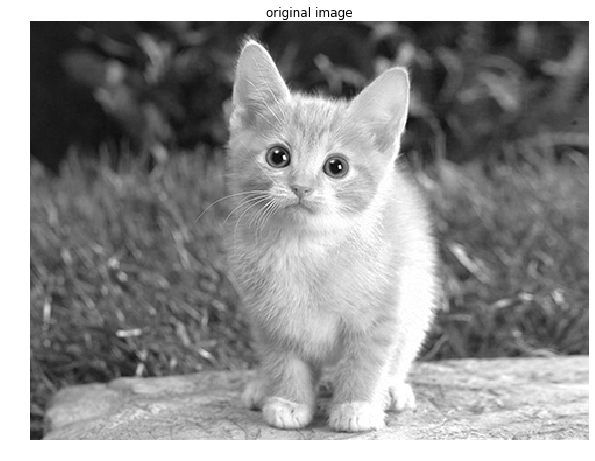

In [2]:
# Load the net, list its data and params, and filter an example image.
caffe.set_mode_cpu()
net = caffe.Net('net_surgery/conv.prototxt', caffe.TEST)
print("blobs {}\nparams {}".format(net.blobs.keys(), net.params.keys()))

# load image and prepare as a single input batch for Caffe
im = np.array(caffe.io.load_image('images/cat_gray.jpg', color=False)).squeeze()
plt.title("original image")
plt.imshow(im)
plt.axis('off')

im_input = im[np.newaxis, np.newaxis, :, :]
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input

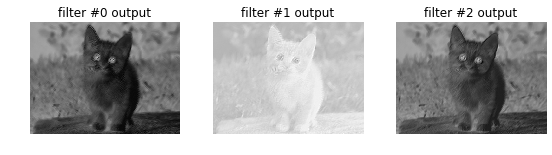

In [3]:
# helper show filter outputs
def show_filters(net):
    net.forward()
    plt.figure()
    filt_min, filt_max = net.blobs['conv'].data.min(), net.blobs['conv'].data.max()
    for i in range(3):
        plt.subplot(1,4,i+2)
        plt.title("filter #{} output".format(i))
        plt.imshow(net.blobs['conv'].data[0, i], vmin=filt_min, vmax=filt_max)
        plt.tight_layout()
        plt.axis('off')

# filter the image with initial 
show_filters(net)

In [4]:
# pick first filter output
conv0 = net.blobs['conv'].data[0, 0]
print("pre-surgery output mean {:.2f}".format(conv0.mean()))
# set first filter bias to 1
net.params['conv'][1].data[0] = 1.
net.forward()
print("post-surgery output mean {:.2f}".format(conv0.mean()))

pre-surgery output mean -0.04
post-surgery output mean 0.96


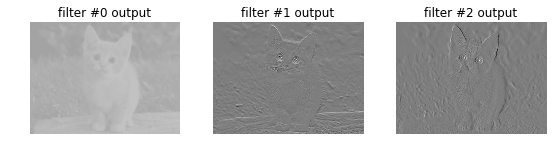

In [5]:
ksize = net.params['conv'][0].data.shape[2:]
# make Gaussian blur
sigma = 1.
y, x = np.mgrid[-ksize[0]//2 + 1:ksize[0]//2 + 1, -ksize[1]//2 + 1:ksize[1]//2 + 1]
g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
gaussian = (g / g.sum()).astype(np.float32)
net.params['conv'][0].data[0] = gaussian
# make Sobel operator for edge detection
net.params['conv'][0].data[1:] = 0.
sobel = np.array((-1, -2, -1, 0, 0, 0, 1, 2, 1), dtype=np.float32).reshape((3,3))
net.params['conv'][0].data[1, 0, 1:-1, 1:-1] = sobel  # horizontal
net.params['conv'][0].data[2, 0, 1:-1, 1:-1] = sobel.T  # vertical
show_filters(net)